In [60]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib
from tqdm.notebook import tqdm
import time

from topostats.filters import Filters
from topostats.grains import Grains
from topostats.grainstats import GrainStats
from topostats.io import find_files, read_yaml, write_yaml, LoadScans
from topostats.logs.logs import setup_logger, LOGGER_NAME
from topostats.utils import update_config

[Tue, 24 Oct 2023 19:07:32] [INFO    ] [topostats] Extracting image from C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemode.gwy
[Tue, 24 Oct 2023 19:07:32] [INFO    ] [topostats] Loading image from : C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemode.gwy
[Tue, 24 Oct 2023 19:07:35] [INFO    ] [topostats] 	(PL-Wavemode) has a topography image with z-height data(m).
[Tue, 24 Oct 2023 19:07:35] [INFO    ] [topostats] [PL-Wavemode] Image added to processing.


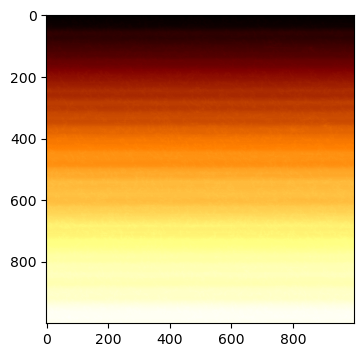

In [63]:
# Set BASE_DIR containing a file and config.yaml
BASE_DIR=Path(os.getcwd())
FILE_EXT = ".gwy"

#IMG_KEY = "PO-Wavemode"
IMG_KEY = "PL-Wavemode"
#IMG_KEY = "polymer"

IMG_FILES = [BASE_DIR.joinpath('data').joinpath(IMG_KEY+".gwy"),]
config = read_yaml(BASE_DIR.joinpath('data').joinpath("polymer_config.yaml"))

#print(json.dumps(config, indent=4)) # print json dump
loading_config = config["loading"]
filter_config = config["filter"]
filter_config.pop("run")
grain_config = config["grains"]
grain_config.pop("run")
loaded_data = LoadScans(IMG_FILES, **config["loading"])
loaded_data.get_data()

# Plot the loaded scan in its raw format
fig, ax = plt.subplots(figsize=(4, 4))
# When Topostats loads .gwy file, aspect ratio of the image is in img_dict.
plt.imshow(loaded_data.image, cmap="afmhot", aspect=loaded_data.img_dict[IMG_KEY]["scale"]["xy_aspect"])
plt.show()

In [64]:
# Filter
filtered_image = Filters(
        image=loaded_data.img_dict[IMG_KEY]["image_original"],
        filename=loaded_data.img_dict[IMG_KEY]["img_path"],
        pixel_to_nm_scaling=loaded_data.img_dict[IMG_KEY]["pixel_to_nm_scaling"],
        **filter_config,)
filtered_image.filter_image()

[Tue, 24 Oct 2023 19:07:39] [INFO    ] [topostats] [C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemode] : Median flattening without mask
[Tue, 24 Oct 2023 19:07:39] [INFO    ] [topostats] [C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemode] : Plane tilt removal without mask
[Tue, 24 Oct 2023 19:07:39] [INFO    ] [topostats] [C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemode] : x-polyfit 1st order: [-2.43870073e-05  1.25039221e-02]
[Tue, 24 Oct 2023 19:07:39] [INFO    ] [topostats] [C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemode] : y-polyfit 1st order: [ 7.62066373e-18 -1.60847000e-14]
[Tue, 24 Oct 2023 19:07:39] [INFO    ] [topostats] [C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detecti

Available NumPy arrays to plot in filter_image.images dictionary :

dict_keys(['pixels', 'initial_median_flatten', 'initial_tilt_removal', 'initial_quadratic_removal', 'initial_scar_removal', 'masked_median_flatten', 'masked_tilt_removal', 'masked_quadratic_removal', 'secondary_scar_removal', 'scar_mask', 'mask', 'zero_average_background', 'gaussian_filtered', 'initial_nonlinear_polynomial_removal', 'masked_nonlinear_polynomial_removal'])


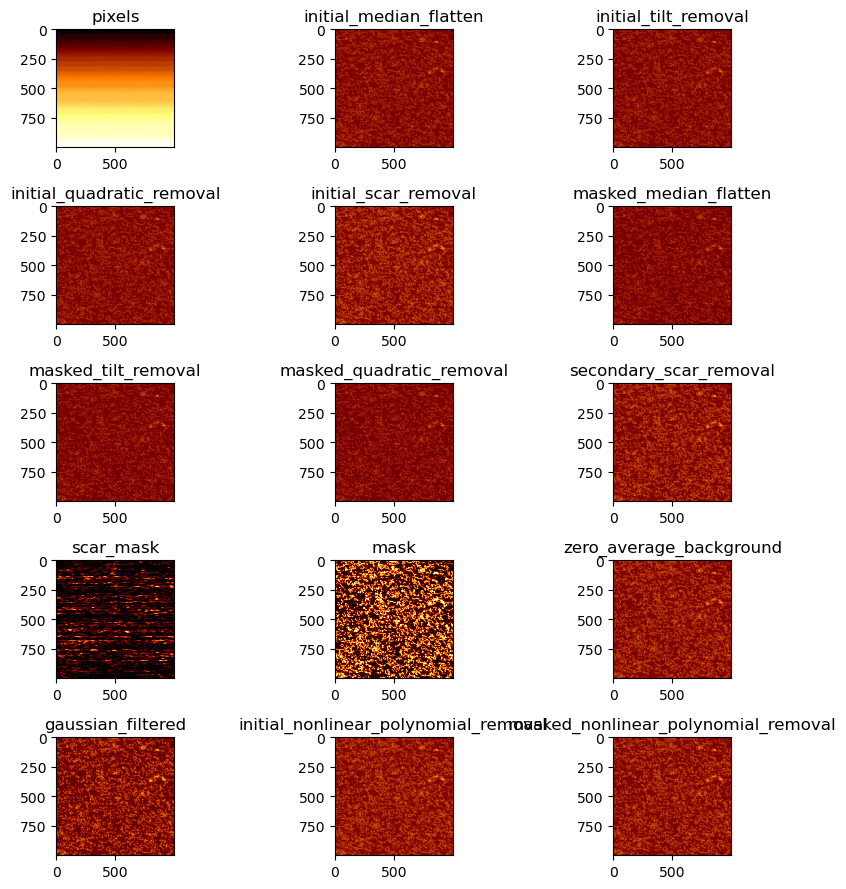

In [65]:
SHOW_TILE = True  # Set True to all images in the filtering result.

def tile_all_images(image_dict, cols):
    key_list = list(image_dict.keys())
    key_count = len(key_list) 
    rows = int((key_count - key_count % cols) / cols)
    fig, ax = plt.subplots(rows,cols,figsize=(9,9))
    idx = 0
    for row in range(rows):
        for col in range(cols):
            key = key_list[idx]
            if image_dict[key] is None:
                continue
            ax[row,col].set_title(key)
            ax[row,col].imshow(image_dict[key], cmap="afmhot")
            idx += 1
            if idx == key_count:
                break
        if idx == key_count:
            break
    fig.tight_layout()
    plt.show()

if SHOW_TILE:
    print(f"Available NumPy arrays to plot in filter_image.images dictionary :\n\n{filtered_image.images.keys()}")
    tile_all_images(filtered_image.images,3)

# Find grains

Here polymer chains are detected by using Grains of Topostats. Resulting Numpy array of "labelled_regions_02" conatins index label starting with 1 for all polymer chains. 

In [66]:
grains = Grains(
                image=filtered_image.images["zero_average_background"],
                filename=filtered_image.filename,
                pixel_to_nm_scaling=filtered_image.pixel_to_nm_scaling,
                **grain_config,
                )
grains.find_grains()
labelled = grains.directions["above"]["labelled_regions_02"]

print(f"Resulting image keys above threshold:\n {grains.directions['above'].keys()}")
print(f"Resuting labelled image of polymer chains:\n count {labelled.max()}, type {type(labelled)}, shape {labelled.shape}")

[Tue, 24 Oct 2023 19:09:07] [INFO    ] [topostats] [C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemode] : Thresholding method (grains) : otsu
[Tue, 24 Oct 2023 19:09:07] [INFO    ] [topostats] [C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemode] : Finding above grains, threshold: (0.18526092825518975)
[Tue, 24 Oct 2023 19:09:07] [INFO    ] [topostats] [C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemode] : Masking (above) Threshold: 0.18526092825518975
[Tue, 24 Oct 2023 19:09:07] [INFO    ] [topostats] [C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemode] : Labelling Regions
[Tue, 24 Oct 2023 19:09:07] [INFO    ] [topostats] [C:\Users\obataya\OneDrive\ドキュメント\02_Work\40_QDJ\_2023_FY14\20231016-第61回生物物理学会ポスター\line_detection\data\PL-Wavemo

In [67]:
lbl1 = grains.directions['above']['labelled_regions_01']
lbl2 = grains.directions['above']['labelled_regions_02']

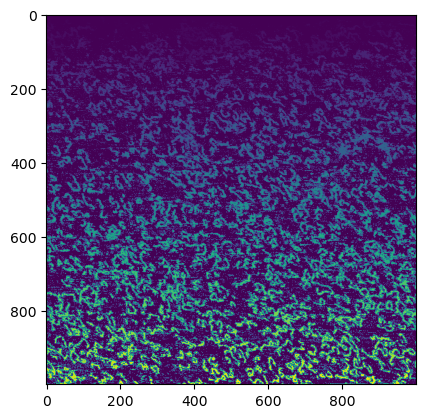

In [71]:
plt.imshow(lbl1)


# Line detection

Linemol module is for detection of linear part of polymer chain of SPM height data. Principle of this analysis is to score all possible lines in a molecule. The score is calculated from the sum of the height values of the pixels that make up the line.

This module has three classes to handle data processing.
- **`Line`** - contains pixel positions of a line
- **`Molecule`** - contains a molecule from preceding grain analysis
- **`LineDetection`** - tools to analyse linear part of molecules to generate results as Pandas.DataFrame

## Data import and filtering by Topostats
Topostats is a Python library for topological data analysis. It provides a set of tools for analyzing and visualizing topological data, such as persistent homology, persistent diagrams, and other related techniques. It is designed to be easy to use and extend, and is suitable for both research and educational purposes. Filtering and finding grains from a Gwyddion file are conducted by Topostats software program. 

## Molecule class
Pixels of each molecule are obtained from grains.directions["above"]["labelled_regions_02"]. A class of `LineDetection` handles the labelled regions ndarray. All molecules are stored as `Molecule` object that provide positions, vectors generated from the positions, methods for detection of linear part.

## Processing
Number of all possible vectors in a molecule sometimes comes enormous, so several steps are implemented to reduce unnecessary lines.

### Qudrants and length filtering
vector pairs are filtered by direction and length. The minimum and maximum length are defined as `min_len` and `max_len` in a config dict.
-  Exclude vectors from the set that are facing the third and fourth quadrants.
-  Exclude vectors exceeding provided minimum and maximum length

### Empty pixel(s) along a line
After collecting the set of vectors, a synthetic straight line is drawn in 2D binary array. When original binary data has gaps along the synthetic line, it is considered to have 'empty' pixels. A line with large number of empty pixels are excluded because it should not be regard as a straight and continuous line. The maximum pixel number is defined as `allowed_empty` in a config dict.

Resulting lines are stored as DataFrame of pandas. Initial dataframe has columns of `mol_idx`, `score`, `pix1`, `pix2`, `angle`

### Overlapping lines
(Not implemented yet) Some lines are covered with a longer line completely, others are covered partially. Shorter and lines with lower score that is covered with other line can be eliminated. In order to prioritize score, dataframe was sorted descending by `score` column.



In [18]:
# assuming linedetection.py is in parent directory of data 
#MOD_DIR=Path(os.getenv('REPO')).joinpath('line_detection')
#sys.path.append(MOD_DIR)
import linemol
importlib.reload(linemol)
from linemol import Molecule, LineDetection, Line

In [ ]:
labelled = grains.directions["above"]["labelled_regions_02"]  # Orn
labelled = grains.directions["above"]["labelled_regions_01"]  # Lys

source = filtered_image.images["gaussian_filtered"]
config = {"min_len":10, "max_len":200,"allowed_empty":2}

ld = LineDetection(labelled, source, **config)

In [20]:
count = 0
time0 = time.perf_counter()
for i in tqdm(range(len(ld.molecules))):
    mol = ld.molecules[i]
    filtered = ld.filter_by_length(mol)
    if filtered is not None:
        lines_cnt = ld.score_lines(mol, filtered)
        if lines_cnt > 0:
            count += 1
time1 = time.perf_counter()
duration = time1 - time0
print(f"{count} molecules calculated in {duration:.3f}")

  0%|          | 0/912 [00:00<?, ?it/s]

766 molecules calculated in 521.941


In [23]:
# Save as pickle
SAVE_FILE = False
if SAVE_FILE:
    ld.score_df.to_pickle(IMG_KEY+"_score_df.pkl.gz")
    ld.stat_df.to_pickle(IMG_KEY+"_stat_df.pkl.gz")

In [34]:
# Result of line detection is in score_df
ld.score_df.loc[ld.score_df["length"]>20].sort_values("norm_score", ascending=False).head(100)

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
222816,858,14.035754,2,11,0,24,41,43.011626,72.407575,6.160007
222817,858,13.735418,1,12,3,24,41,39.849718,72.474432,5.963169
105282,437,20.134458,1,2,1,20,56,57.870545,71.878140,5.800462
222818,858,13.442703,2,11,0,23,38,39.849718,72.474432,5.771326
36564,150,14.053859,2,11,1,23,39,39.849718,72.474432,5.715121
...,...,...,...,...,...,...,...,...,...,...
77477,346,8.807930,2,2,2,14,29,29.546573,66.037511,4.789460
49544,213,12.726370,2,9,13,45,34,41.677332,30.256437,4.787899
222837,858,11.939769,2,12,5,24,38,35.114100,70.016893,4.786314
58211,273,18.295910,2,7,2,16,46,44.911023,78.439869,4.779565


In [25]:
# Filtering statistics is in stat_df
ld.stat_df.sort_values("len_filtered", ascending=False).head()

,mol_idx,pixels,total_vecs,len_filtered,total_lines,min_len,max_len,max_pix,score_cutoff
436,437,498,123753,99187,NaN,10,200,500,NaN
379,380,457,104196,87726,NaN,10,200,500,NaN
832,833,456,103740,85259,NaN,10,200,500,NaN
423,424,470,110215,85129,NaN,10,200,500,NaN
729,730,470,110215,84530,NaN,10,200,500,NaN


In [26]:
len(ld.line_cache), ld.line_cache_hit, 89207/300546

(1573055, (3982744, 5555799), 0.2968164607081778)

In [27]:
len(ld.score_df.loc[ld.score_df["mol_idx"]==39])

0

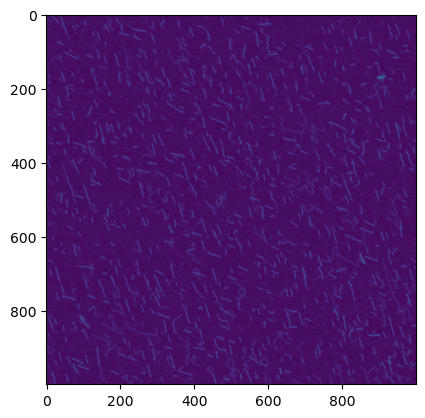

In [57]:
overlaid = ld.overlay_lines(num_lines=1, factor=3)
plt.imshow(overlaid)

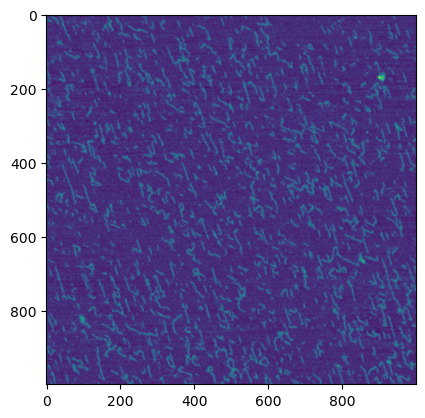

In [29]:
plt.imshow(ld.source_img)

<AxesSubplot:xlabel='angle', ylabel='score'>

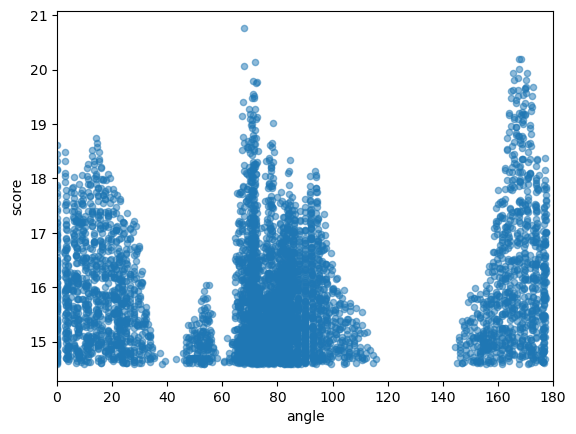

In [55]:
sorted_df = ld.score_df.sort_values("score",ascending=False)
sorted_df[0:5000].plot.scatter(x="angle", y='score', alpha=0.5, xlim=(0,180))

[]

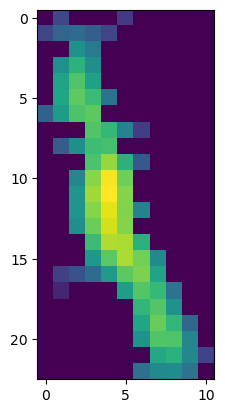

In [35]:
idx = 858
mol = ld.molecules[idx]
mol_image = mol.get_source_image()
plt.imshow(mol_image)
plt.plot()

In [36]:
def draw_line_by_id(mol:Molecule, pidx1:int, pidx2:int, height, width) -> np.ndarray:
    (y1, x1) = mol.get_yx(pidx1)
    (y2, x2) = mol.get_yx(pidx2)
    return LineDetection.draw_line(x1, y1, x2, y2, height, width)

overlapped = np.zeros((line_count, line_count), dtype=bool)

covered = set()
covered_pair = []
for i in range(line_count):
    if i in covered:
        continue
    line_i = draw_line_by_id(mol, px_ids1[i],px_ids2[i],mol.height, mol.width)
    count_i = line_i.sum()
    for j in range(i+1, line_count):
        if j in covered:
            continue
        line_j = draw_line_by_id(mol, px_ids1[j],px_ids2[j],mol.height, mol.width)
        count_j = line_j.sum()
        shorter = min(count_i, count_j)
        if (line_i & line_j).sum() == shorter:
            if line_i.sum() <= line_j.sum():  # line_i is covered with line_j
                covered.add(i)
                covered_pair.append([i,j])
            else:
                covered.add(j)
                covered_pair.append([j,i])

NameError: name 'line_count' is not defined

# Normalized score

This normalization should be conducted for each molecule.

In [40]:
df = ld.score_df
mol_df = df.loc[(df["mol_idx"]==mol.mol_idx)].sort_values("norm_score",ascending=False)
mol_df[:3]

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
224066,859,8.497393,0,1,0,8,22,23.086793,72.349876,2.907539
224067,859,8.286707,0,1,0,7,22,22.803509,74.744881,2.734343
224068,859,8.242182,0,1,0,7,21,21.840330,74.054604,2.697741


In [41]:
def plot_emphasized_by_score(ld, mol, ilocs, use_max=False):
    """ Plot an emphasized line in src image"""
    mol_score = ld.score_df.loc[ld.score_df["mol_idx"]==mol.mol_idx]
    if len(mol_score)==0:
        return
    line_mask = mol.get_blank()
    for iloc in ilocs:
        row = mol_score.iloc[iloc].tolist()
        (x1,y1,x2,y2) = tuple(row[3:7])
        l = Line.create_from_pos(x1,y1,x2,y2).get_mask(mol.height, mol.width)
        line_mask = line_mask + l
    line_mask = line_mask / (len(ilocs))
    emp = ld.get_emphasized(mol,line_mask,factor=1.5, use_max=True)
    plt.imshow(emp)
    plt.plot()


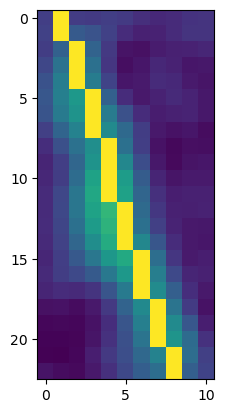

In [42]:
plot_emphasized_by_score(ld, mol,range(0,1))

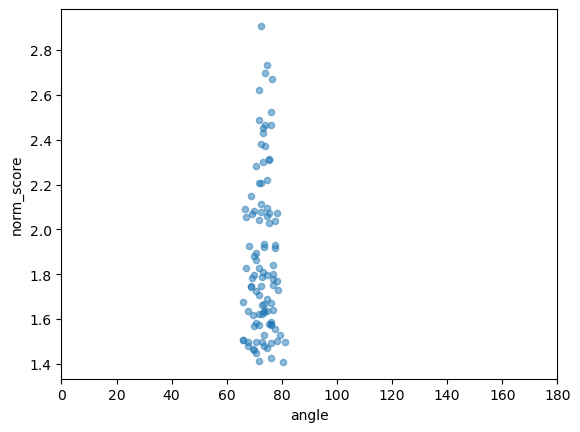

In [43]:
ret_mol = mol_df[0:100].plot.scatter(x="angle", y='norm_score', alpha=0.5, xlim=(0,180))

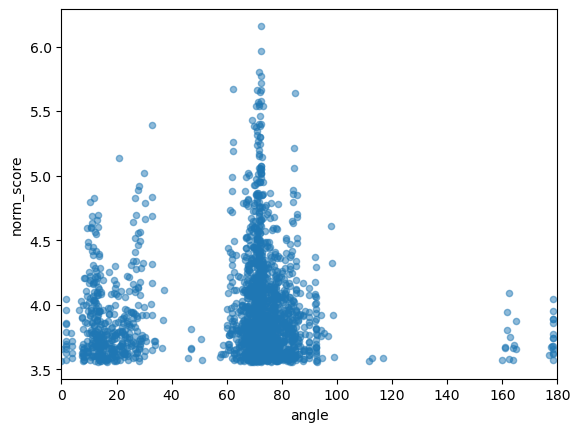

In [44]:
ret_all = df.sort_values("norm_score",ascending=False)[0:2000].plot.scatter(x="angle", y='norm_score', alpha=0.5, xlim=(0,180))

<AxesSubplot:ylabel='Frequency'>

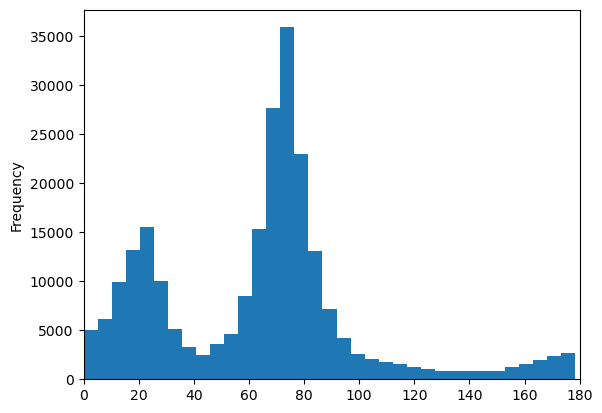

In [45]:

ld.score_df["angle"].plot.hist(bins=35, xlim=(0,180))


[]

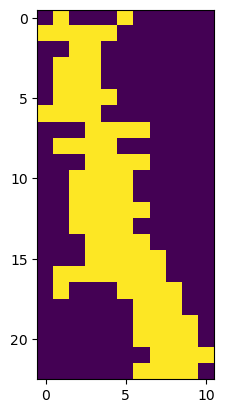

In [47]:
plt.imshow(ld.molecules[858].get_mask())
plt.plot()

In [48]:
sys.getsizeof(ld.score_df)

58700616